In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import arviz as az
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import scipy.stats as stats
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

[INFO] [2021.10.22 0:36:14 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2021.10.22 0:36:14 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Oct  8 2021 07:17:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 
TABLE_PATH = "./../latex/tables" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)


def tab_path(tab_id):
    """
    Input name of table to load or save with extension as dtype str
    """
    return os.path.join(TABLE_PATH + "/", tab_id)


def df_to_latex(df, outfile):
    """
    Render dataframe to a LaTeX tabular environment table and write to file
    """
    n = len(df.columns)
    col_format = n * 'c'
    # Render dataframe to a LaTeX tabular environment table and write to file
    pd.options.display.float_format = '{:,.3f}'.format
    df = df.apply(lambda x: x.astype(
        int) if np.allclose(x, x.astype(int)) else x)
    pd.options.display.latex.escape = False
    latex = df.to_latex(index=False, column_format=col_format)
    latex = latex.replace('\\toprule', '\\hline \\hline')
    latex = latex.replace('\\midrule', '\\hline \\hline')
    latex = latex.replace('\\bottomrule', '\\hline \\hline')

    with open(tab_path(outfile), 'w') as f:
        f.write(latex)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


In [3]:
path = "data/"

In [4]:
def hh_posterior_predictive(obs_data, simulator, thetas_pred, ax=None):
    if ax is None:
        ax = plt.gca()
        
    post_preds = np.array([simulator(*theta) for theta in thetas_pred])
    mean_pred = np.mean(post_preds, axis=0)
    
    p1, = ax.plot(obs_data[1], obs_data[0], color='k', lw=1.0, zorder=1)
    
    for pred in post_preds:
        p2, = ax.plot(pred[1], pred[0], color='C0', alpha=0.2, zorder=0)
    
    p3, = ax.plot(mean_pred[1], mean_pred[0], color='C1', ls='--', dashes=(5, 5), lw=1.0, zorder=2)
    
    ax.set(xlabel="Time (ms)",
           ylabel="Membrane Potential (mV)"
          )
    
    ax.legend(
        [p1, p2, p3],
        ['Observation', 'Posterior predictive', 'Posterior predictive mean'],
        loc='center left',
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False
    )

In [ ]:
# Simulator model
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]
stimulus = nm.stimulus.Constant(I_amp, t_stim_on, t_stim_off)
hh = nm.models.HodgkinHuxley(stimulus, T, dt)

# Summary statistics calculator
s_stats = ["average_AP_overshoot",
           "spike_rate",
           "average_AP_width",
           "average_AHP_depth",
           "latency_to_first_spike",
           "accommodation_index"
          ]

sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on,
                               t_stim_off=t_stim_off,
                               stats=s_stats
                               )

# Observed data
gbarK0 = 36.
gbarNa0 = 120.

V, t = hh(gbar_K=gbarK0, gbar_Na=gbarNa0)

fig = hh.plot_voltage_trace(with_stim=True) 
plt.show()

In [ ]:
# number of spikes
n_spikes = sps.n_spikes(V, t)
print(f"{n_spikes=}")

# average AP overshoot
average_AP_overshoot = sps.average_AP_overshoot(V, t)
print(f"{average_AP_overshoot=:.4f} mV")

# spike rate
spike_rate = sps.spike_rate(V, t)
print(f"{spike_rate=:.4f} mHz")

# average AP width
average_AP_width = sps.average_AP_width(V, t)
print(f"{average_AP_width=:.4f} mV")

# average AHP depth
average_AHP_depth = sps.average_AHP_depth(V, t)
print(f"{average_AHP_depth=:.4f} mV")

# latency to first spike
latency_to_first_spike = sps.latency_to_first_spike(V, t)
print(f"{latency_to_first_spike=:.4f} ms")

# accommodation index
accommodation_index = sps.accommodation_index(V, t)
print(f"{accommodation_index=:.17f}")

In [ ]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
hh.plot_spike_statistics2(t_stim_on, t_stim_off, ax=ax)
plt.show()

# HH model with noisy observation 

## Observed sum stats

In [ ]:
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]

# Observed data
df = pd.read_csv('data/hh_noisy.csv')
V = df["V"].to_numpy()
t = df["t"].to_numpy()

# Summary statistics calculator
s_stats = ["average_AP_overshoot",
           "spike_rate",
           "average_AP_width",
           "average_AHP_depth",
           "latency_to_first_spike",
           "accommodation_index"
          ]

sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on,
                               t_stim_off=t_stim_off,
                               stats=s_stats
                               )

# number of spikes
n_spikes = sps.n_spikes(V, t)
print(f"{n_spikes=}")

# average AP overshoot
average_AP_overshoot = sps.average_AP_overshoot(V, t)
print(f"{average_AP_overshoot=:.4f} mV")

# spike rate
spike_rate = sps.spike_rate(V, t)
print(f"{spike_rate=:.4f} mHz")

# average AP width
average_AP_width = sps.average_AP_width(V, t)
print(f"{average_AP_width=:.4f} mV")

# average AHP depth
average_AHP_depth = sps.average_AHP_depth(V, t)
print(f"{average_AHP_depth=:.4f} mV")

# latency to first spike
latency_to_first_spike = sps.latency_to_first_spike(V, t)
print(f"{latency_to_first_spike=:.4f} ms")

# accommodation index
accommodation_index = sps.accommodation_index(V, t)
print(f"{accommodation_index=:.17f}")

n_spikes=7
average_AP_overshoot=30.7316 mV
spike_rate=0.0700 mHz
average_AP_width=2.0501 mV
average_AHP_depth=-74.2234 mV
latency_to_first_spike=2.3000 ms
accommodation_index=0.00000000000000002

In [ ]:
from scipy.signal import find_peaks

# Observed data
df = pd.read_csv('data/hh_noisy.csv')
V = df["V"].to_numpy()
t = df["t"].to_numpy()

fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

rfp = 12.2
d = np.abs(t - rfp).argmin()

peaks, _ = find_peaks(V, height=0, distance=d)

reverse_peaks, _ = find_peaks(-V[peaks[0]:peaks[-1]], height=0, distance=d)
ax.plot(t[reverse_peaks + peaks[0]], V[reverse_peaks + peaks[0]], "o")

print(len(peaks))

print(V[peaks[0]:])

ax.plot(t, V)
ax.plot(t, -V)
ax.plot(t[peaks[0]:], V[peaks[0]:])
ax.plot(t[peaks], V[peaks], "x")
ax.plot(t[reverse_peaks + peaks[0]], V[reverse_peaks + peaks[0]], "o")
plt.show()

### Noisy data, simulator model without current noise

In [5]:
# Observed data
df = pd.read_csv('data/hh_noisy.csv')
V = df["V"].to_numpy()
t = df["t"].to_numpy()
obs_data = (V, t)

# Simulator model
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]
stimulus = nm.stimulus.Constant(I_amp, t_stim_on, t_stim_off)
hh = nm.models.HodgkinHuxley(stimulus, T, dt)

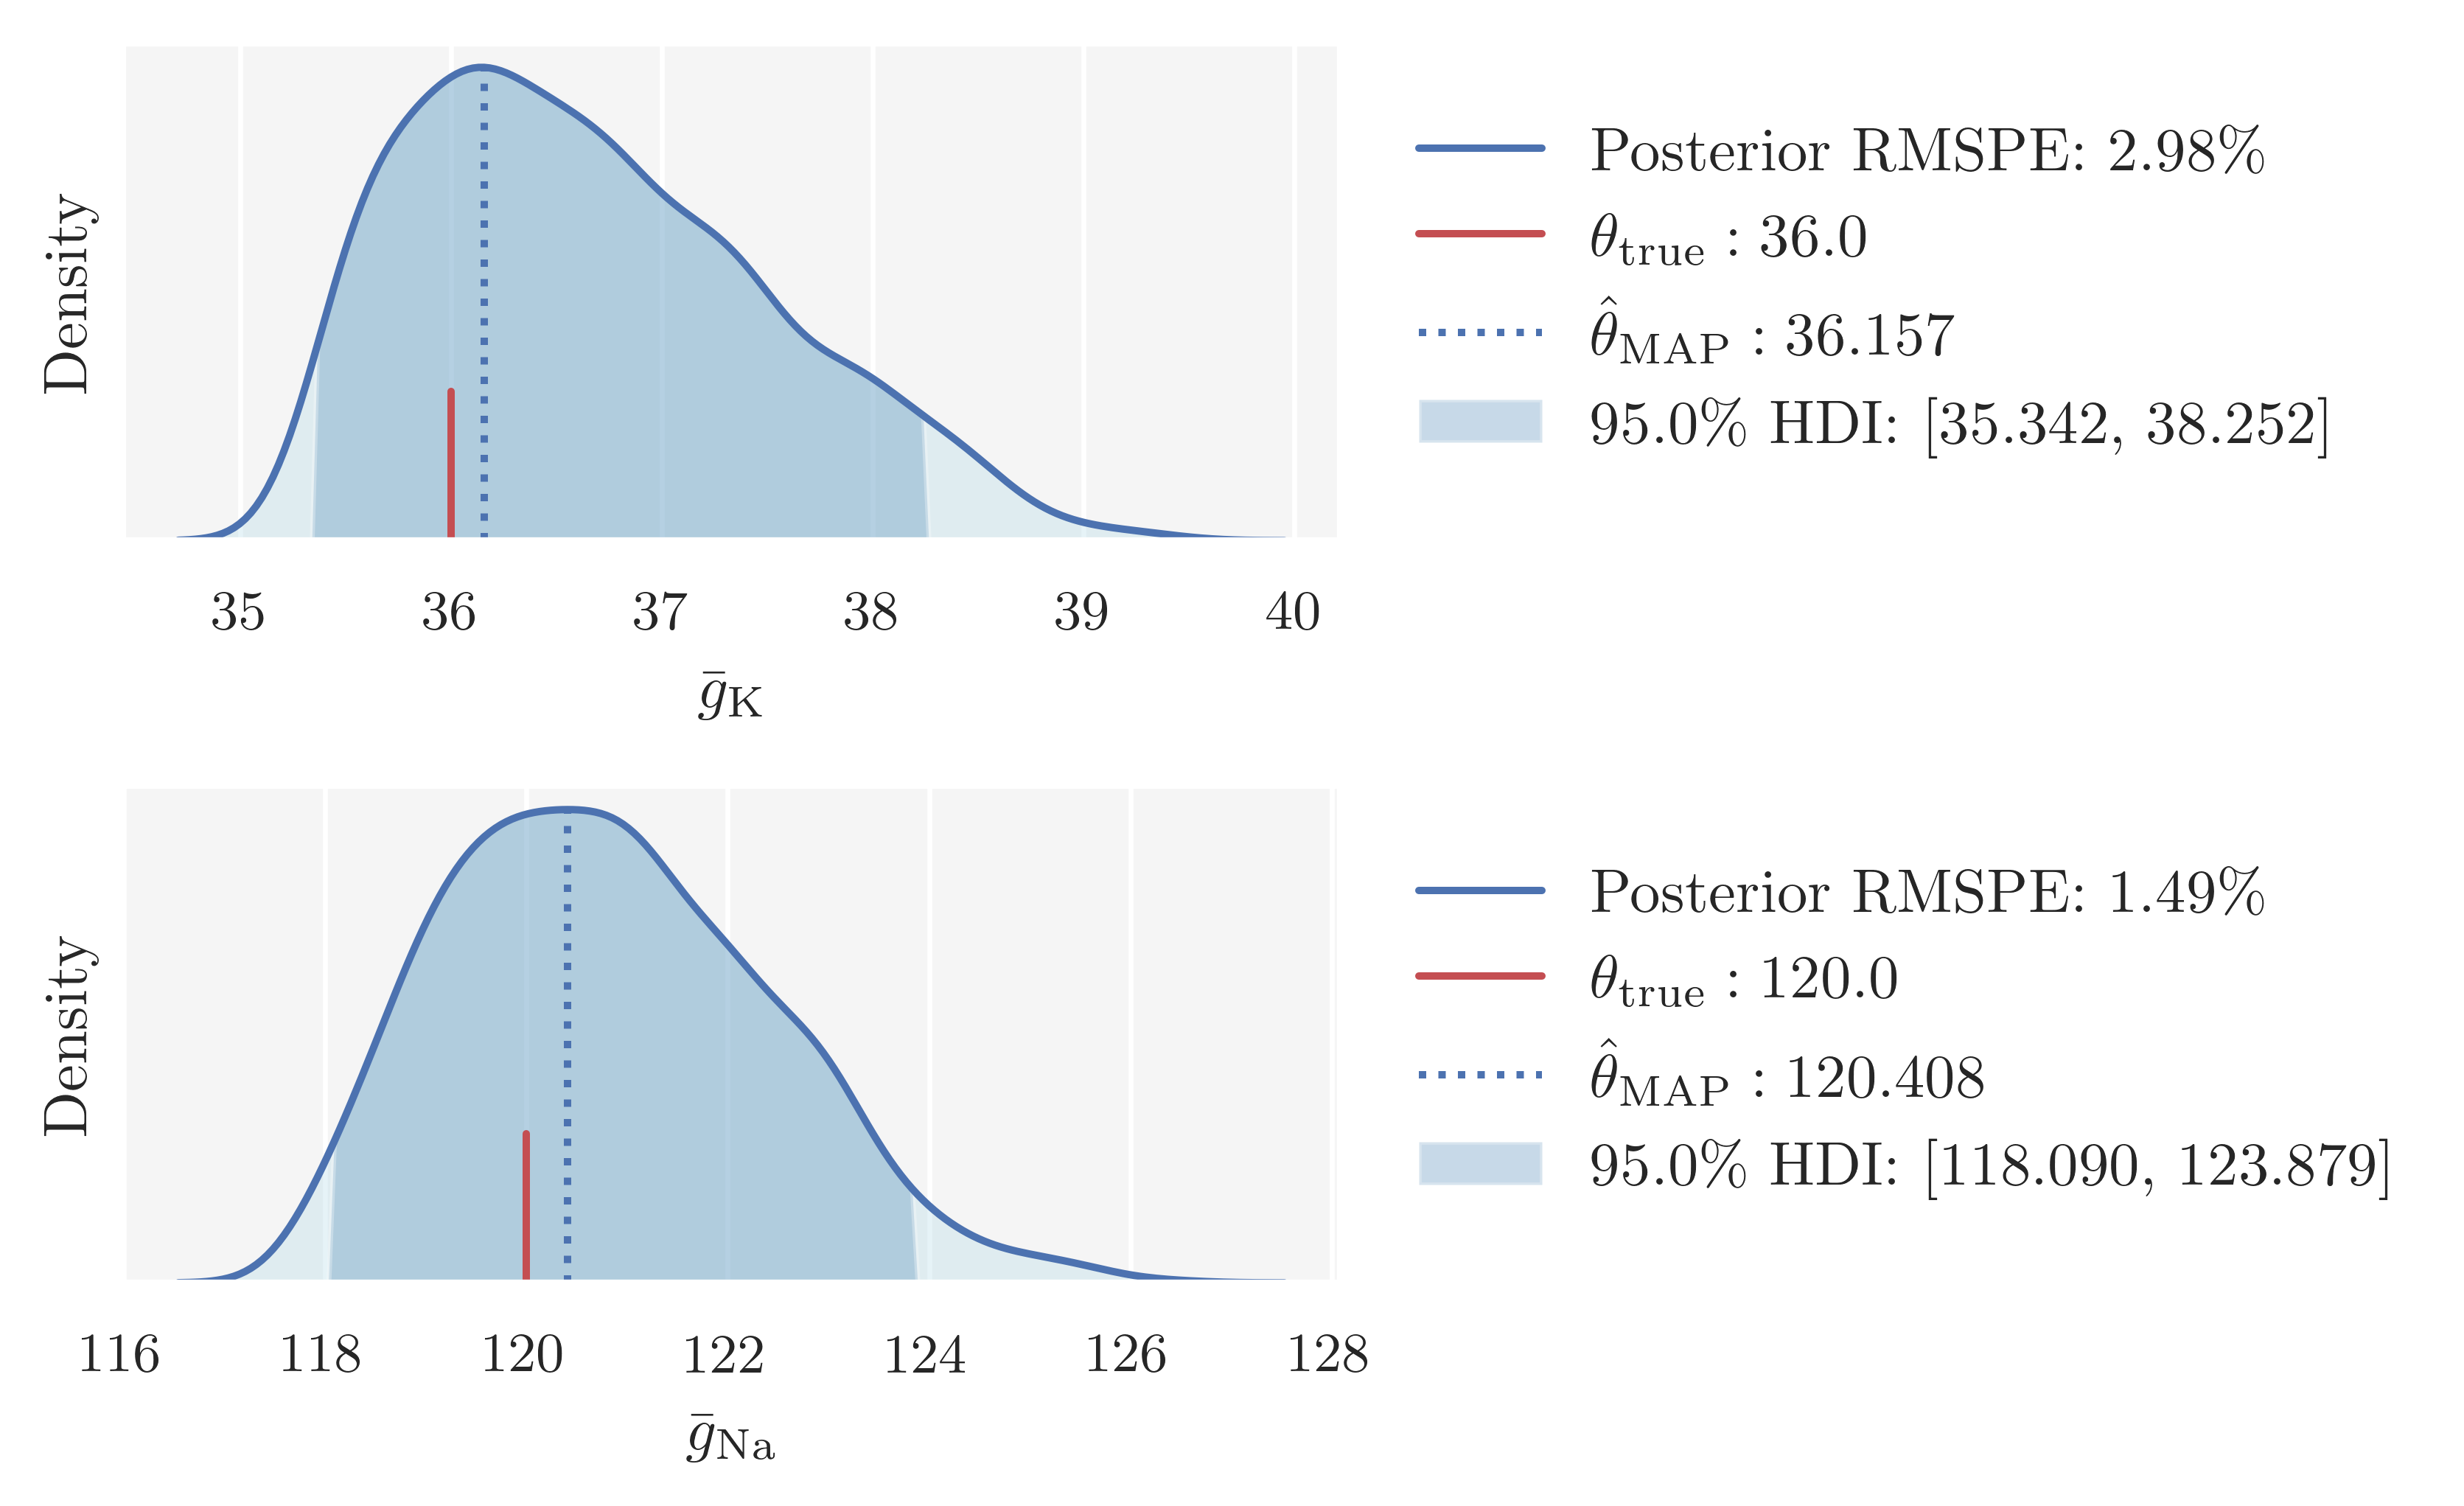

In [6]:
filename = f'hh_clean_rej_noisy_posterior_org.jnl'
journal_org = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_org.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_org.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1]) 

fig.savefig(fig_path('hh_posterior_org_noisy.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

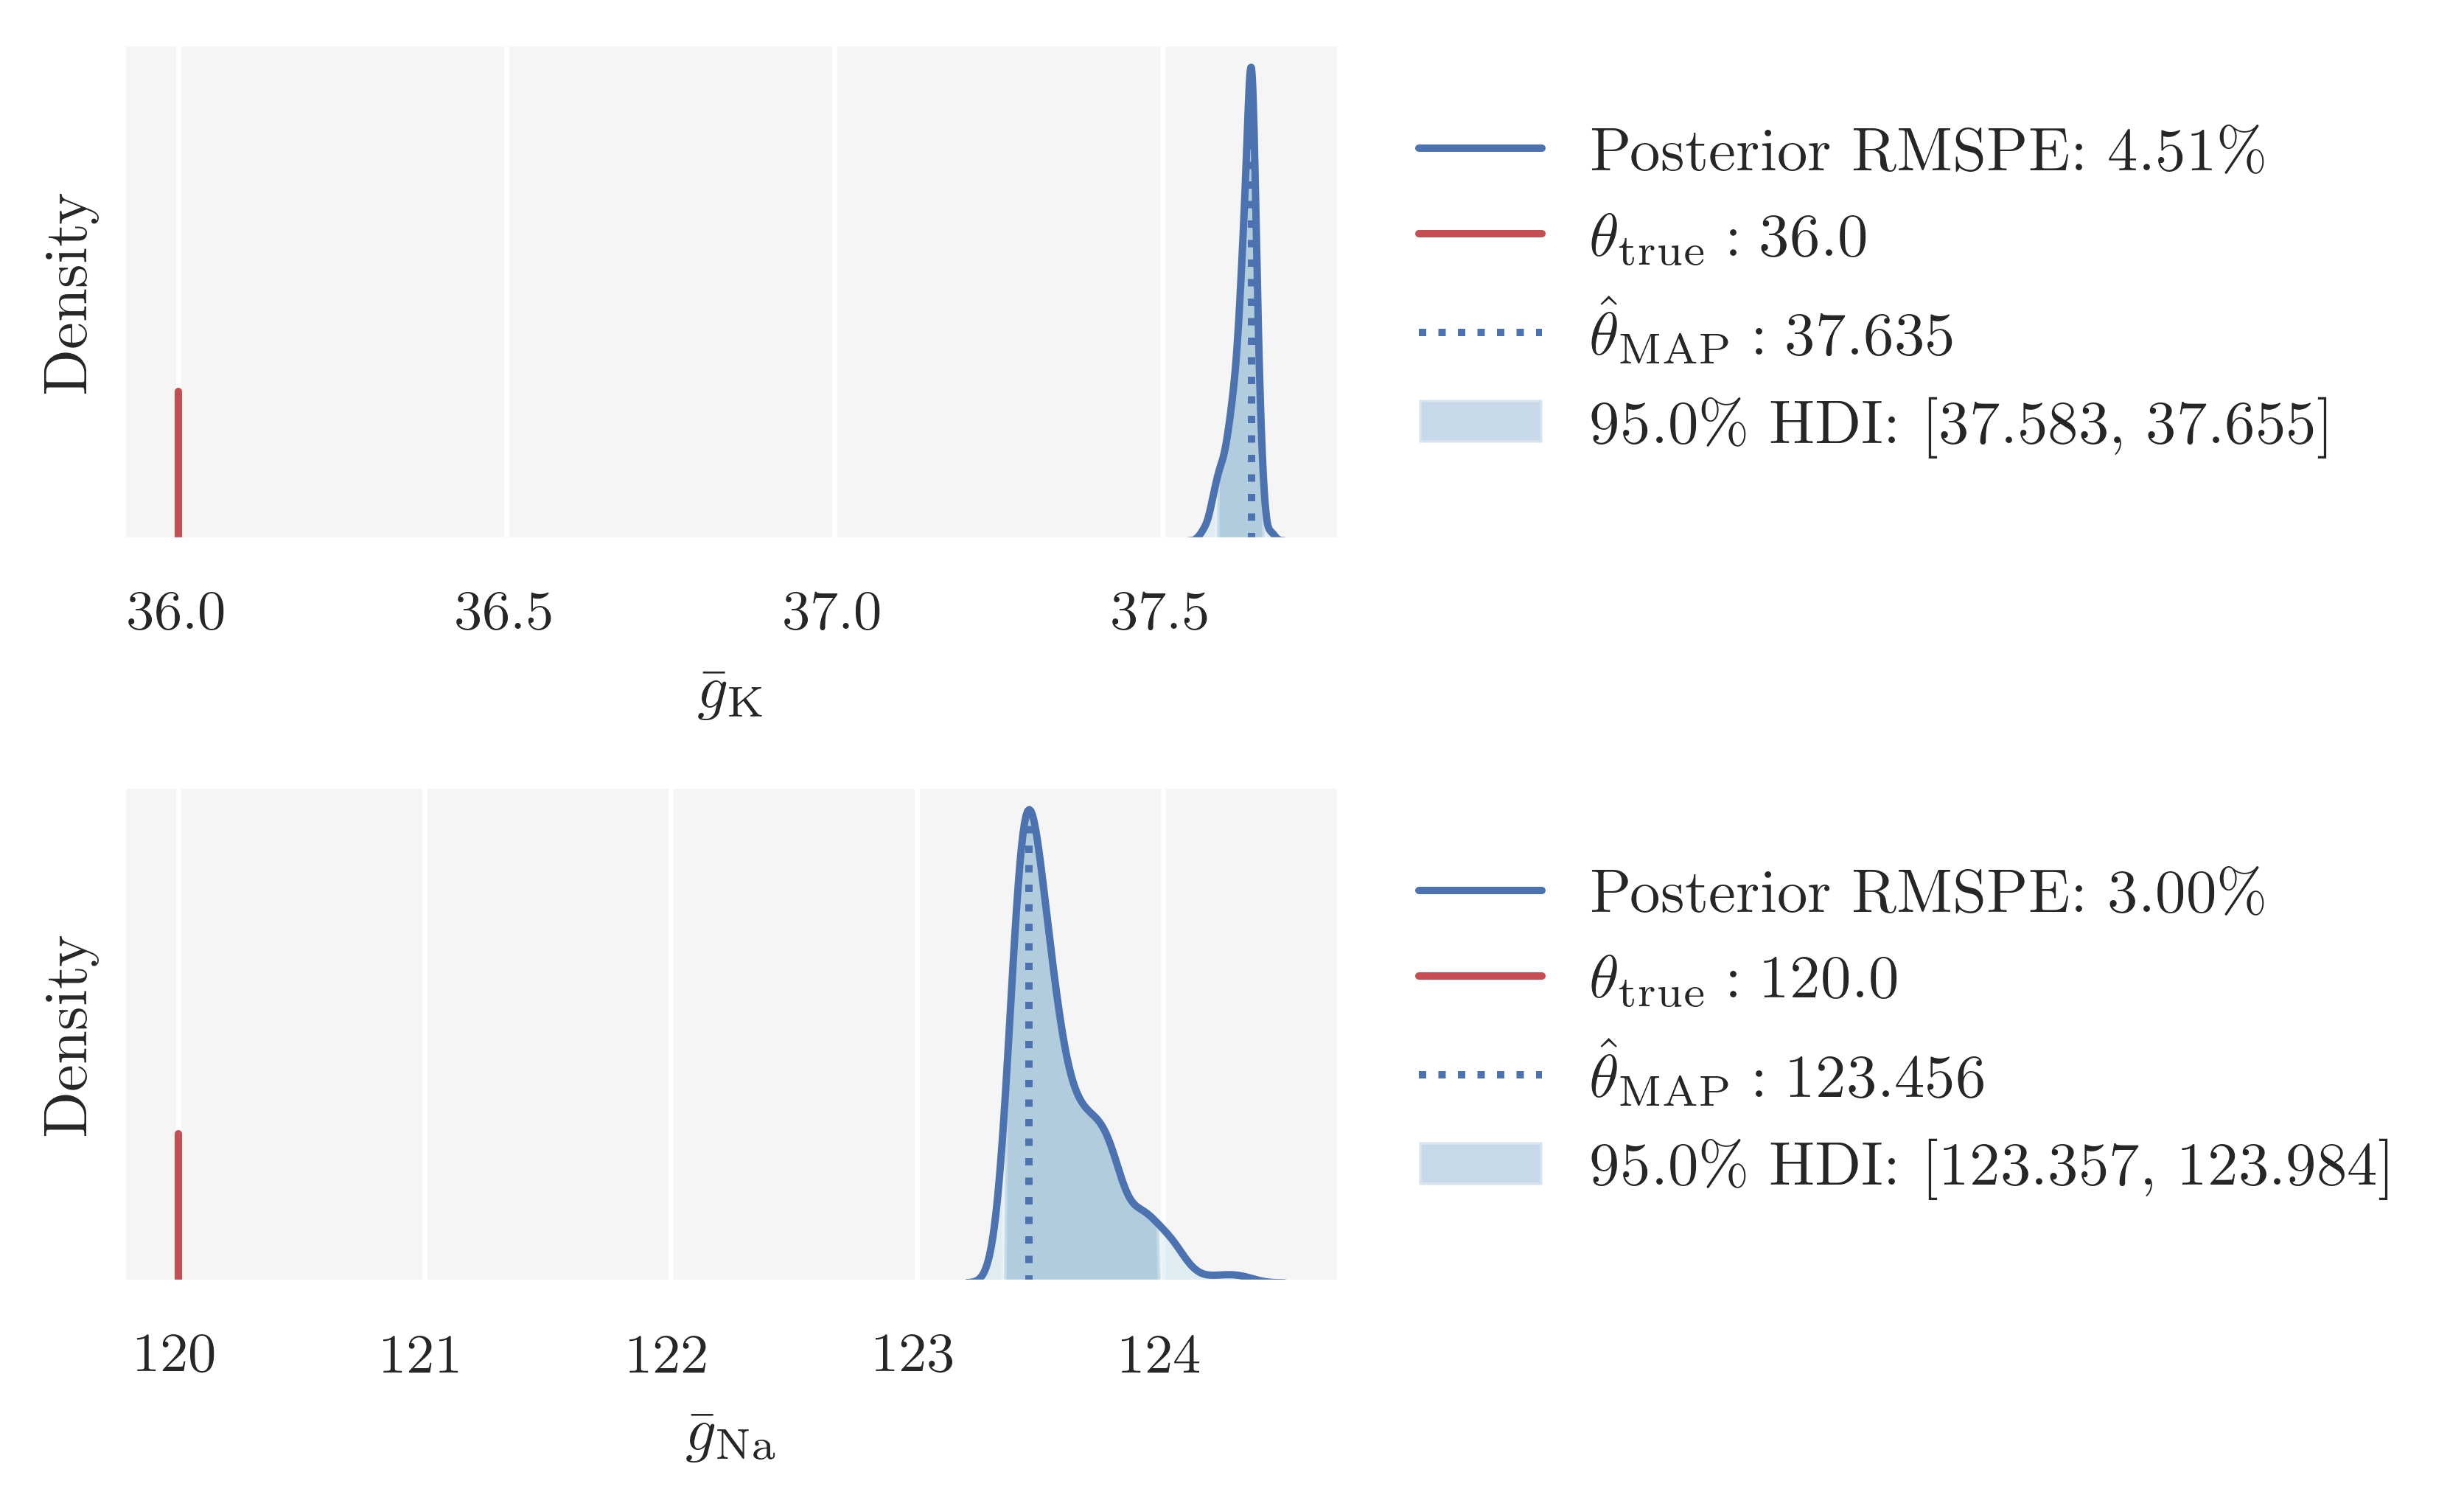

In [7]:
filename = f'hh_clean_rej_noisy_posterior_reg.jnl'
journal_reg = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_reg.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_reg.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1]) 

fig.savefig(fig_path('hh_posterior_reg_noisy.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

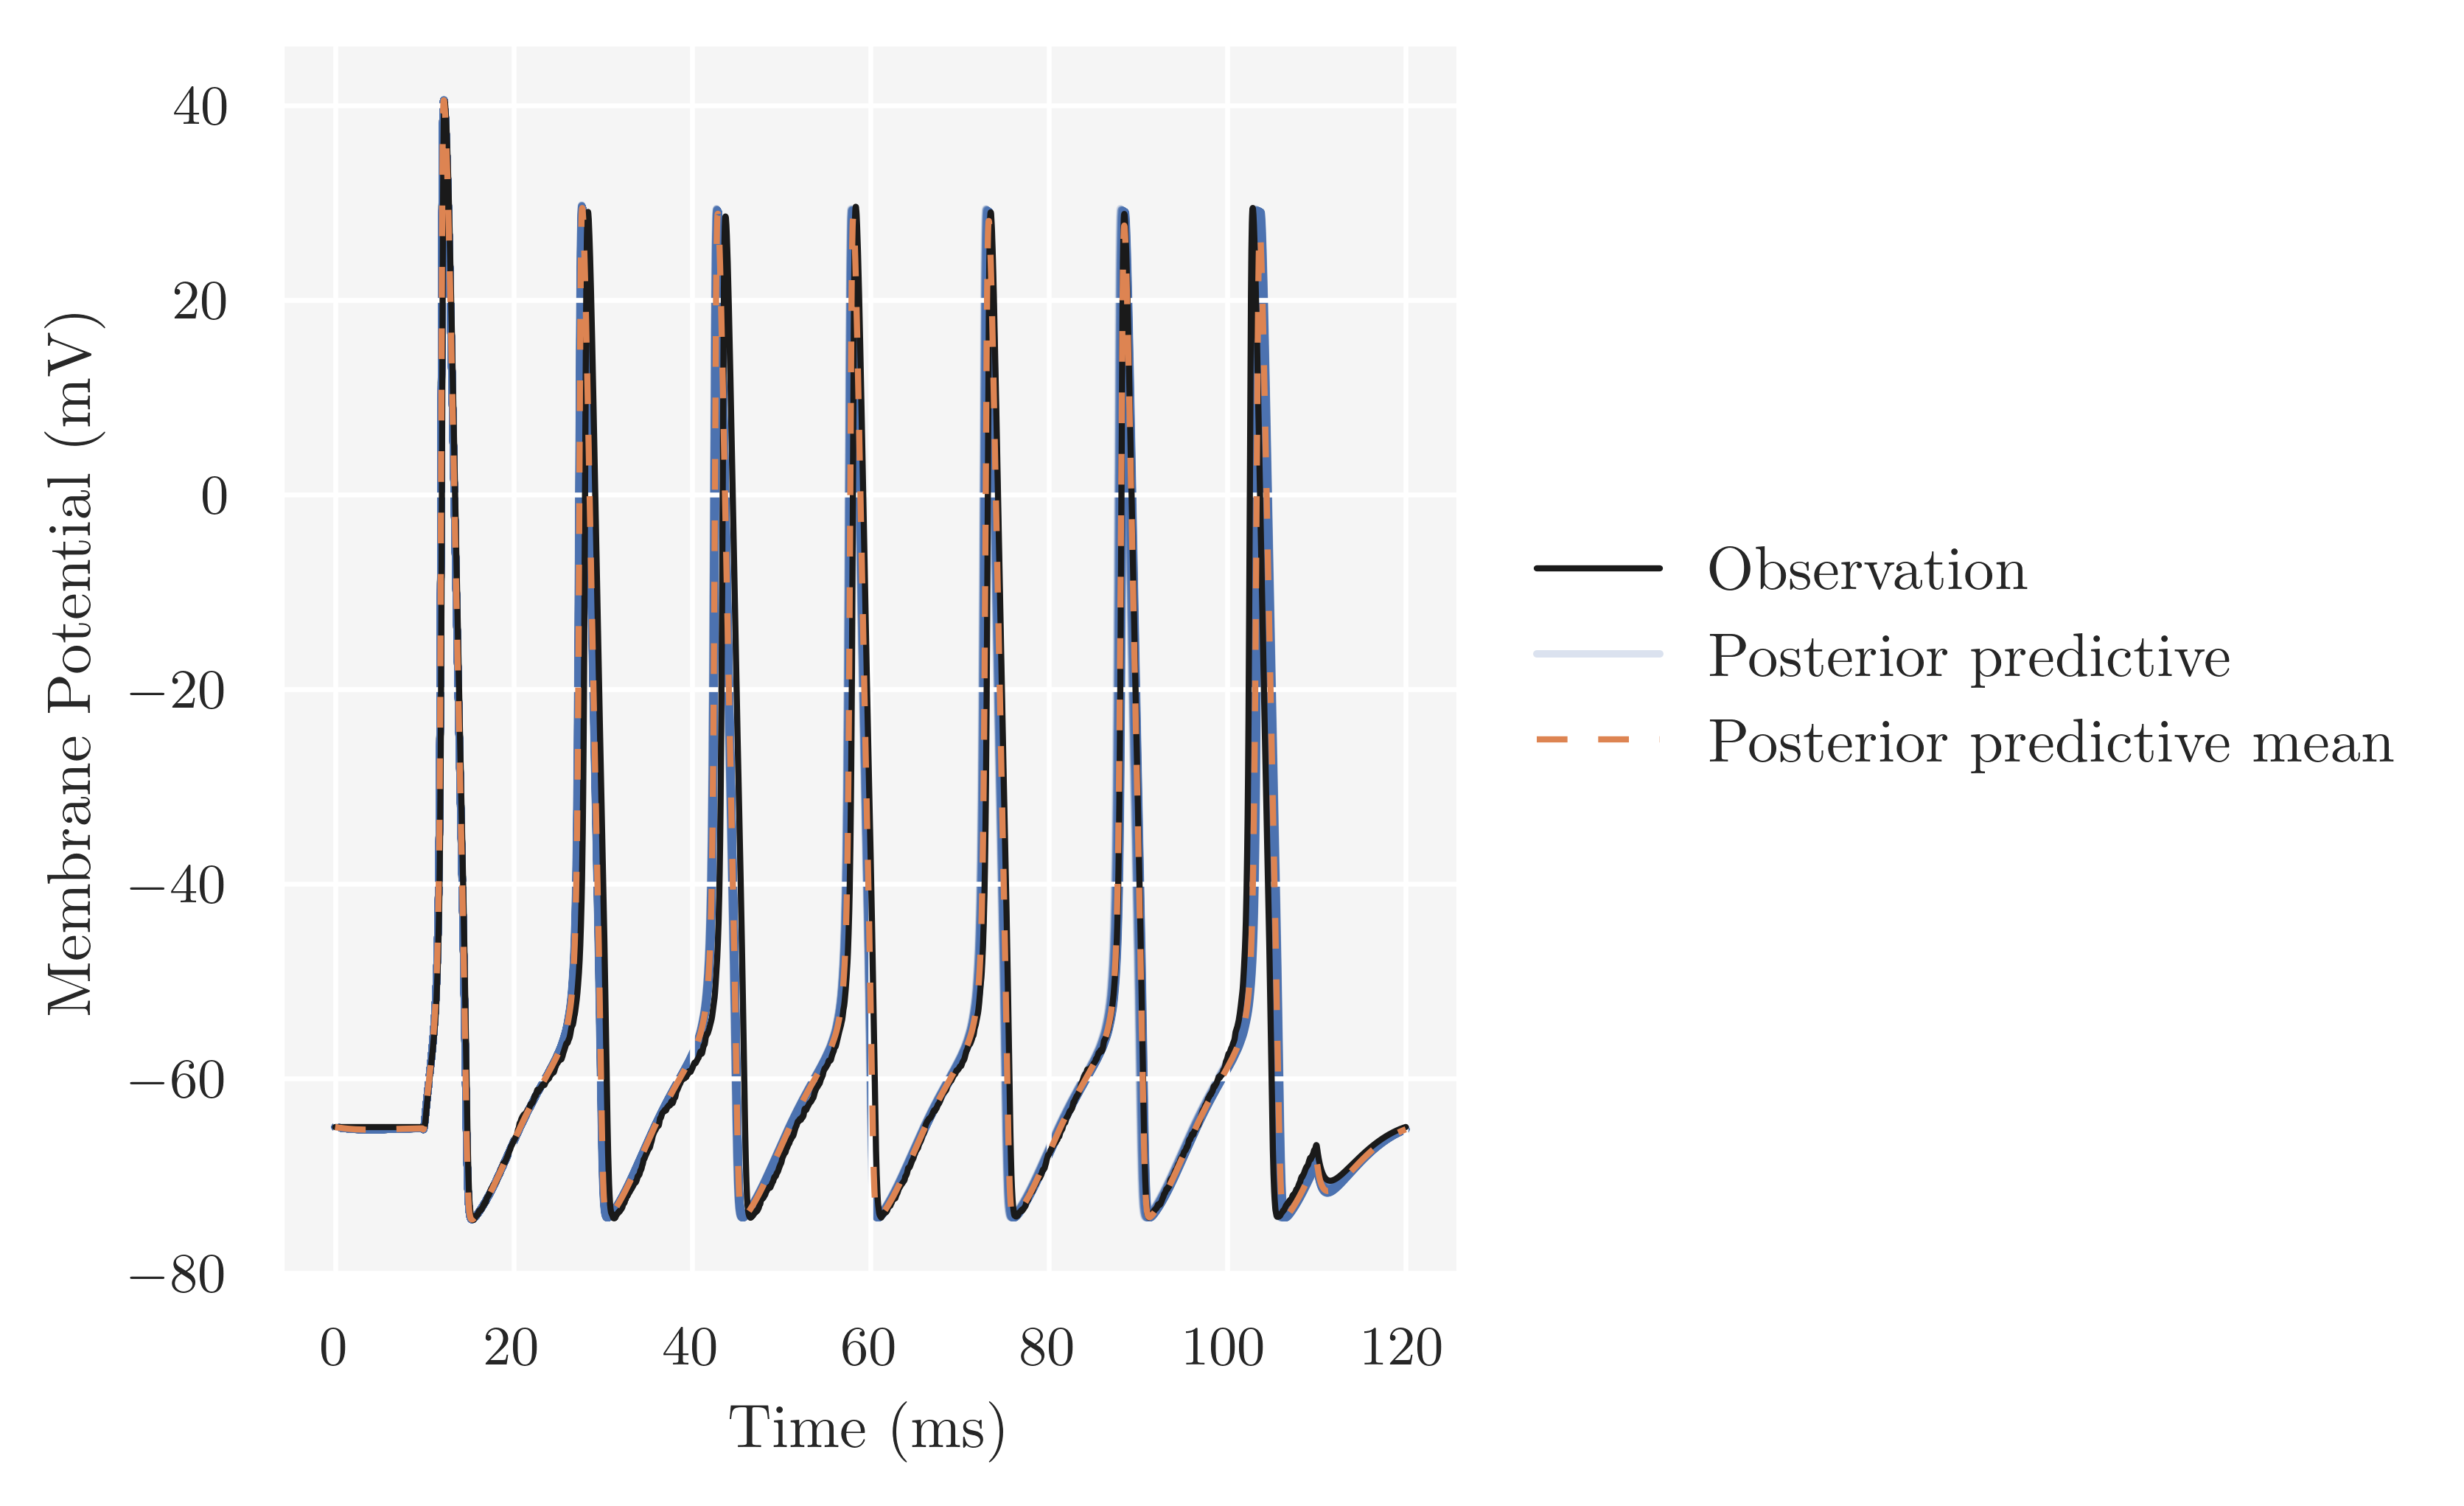

In [8]:
size = 100
thetas_pred = journal_reg.thetas_pred(size)

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
hh_posterior_predictive(obs_data, hh, thetas_pred, ax=ax)

fig.savefig(fig_path('hh_postpred_reg_noisy.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Noisy data, simulator model with current noise

In [ ]:
# Observed data
df = pd.read_csv('data/hh_noisy.csv')
V = df["V"].to_numpy()
t = df["t"].to_numpy()
obs_data = (V, t)

# Simulator model
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]
noise_scale = 1.
stimulus_noisy = nm.stimulus.NoisyConstant(I_amp,
                                           t_stim_on,
                                           t_stim_off,
                                           noise_scale=noise_scale)
hh_noisy = nm.models.HodgkinHuxley(stimulus_noisy, T, dt)

In [ ]:
filename = f'hh_noise_rej_noisy_posterior_org.jnl'
journal_org = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_org.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_org.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1]) 

plt.show()

In [ ]:
filename = f'hh_noise_rej_noisy_posterior_reg.jnl'
journal_reg = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_reg.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_reg.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1]) 

plt.show()

In [ ]:
size = 100
thetas_pred = journal_reg.thetas_pred(size)

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
hh_posterior_predictive(obs_data, hh_noisy, thetas_pred, ax=ax)
plt.show()

# OLD

In [ ]:
# Observed data
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
noise_scale=4
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]
stimulus = nm.stimulus.NoisyConstant(I_amp, t_stim_on, t_stim_off, noise_scale=noise_scale)
hh = nm.models.HodgkinHuxley(stimulus, T, dt)

# Summary statistics calculator
s_stats = ["average_AP_overshoot",
           "spike_rate",
           "average_AP_width",
           "average_AHP_depth",
           "latency_to_first_spike",
           "accommodation_index"
          ]

sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on,
                               t_stim_off=t_stim_off,
                               stats=s_stats
                               )

# Observed data
gbarK0 = 36.
gbarNa0 = 120.

V, t = hh(gbar_K=gbarK0, gbar_Na=gbarNa0)
obs_data = (V, t)

fig = hh.plot_voltage_trace(with_stim=True) 

print(sps(V, t))

In [ ]:
noise = np.random.default_rng(42).normal(0, 0.1, V.shape)
Vnoisy = V + noise

plt.plot(t, Vnoisy)
plt.show()

## Posteriors

In [ ]:
path = "data/"
filename = f'hh_rej_noisy_posterior_org.jnl'
journal_org = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_org.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_org.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1]) 

plt.show()

In [ ]:
filename = f'hh_rej_noisy_posterior_reg.jnl'
journal_reg = pylfi.Journal.load(path + filename)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
journal_reg.plot_posterior('gbarK', point_estimate='map', theta_true=36., ax=axes[0])
journal_reg.plot_posterior('gbarNa', point_estimate='map', theta_true=120., ax=axes[1]) 

plt.show()

In [ ]:
df_reg = journal_reg.df
df_reg

In [ ]:
def hh_posterior_predictive(obs_data, simulator, thetas_pred, ax=None):
    if ax is None:
        ax = plt.gca()
        
    post_preds = np.array([simulator(*theta) for theta in thetas_pred])
    mean_pred = np.mean(post_preds, axis=0)
    
    p1, = ax.plot(obs_data[1], obs_data[0], color='k', lw=1.0, zorder=1)
    
    for pred in post_preds:
        p2, = ax.plot(pred[1], pred[0], color='C0', alpha=0.2, zorder=0)
    
    p3, = ax.plot(mean_pred[1], mean_pred[0], color='C1', ls='--', dashes=(5, 5), lw=1.0, zorder=2)
    
    ax.set(xlabel="Time (ms)",
           ylabel="Membrane Potential (mV)"
          )
    
    ax.legend(
        [p1, p2, p3],
        ['Observation', 'Posterior predictive', 'Posterior predictive mean'],
        loc='center left',
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False
    )

In [ ]:
size = 50
thetas_pred = journal_reg.thetas_pred(size)

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
hh_posterior_predictive(obs_data, hh, thetas_pred, ax=ax)
plt.show()